In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline

In [2]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [3]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [4]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

In [5]:
def clean(row):
    if row['extra_runs']>= row['batsman_runs']:
        row['extra_runs'] -= row['batsman_runs']
        
    return row

delivery = delivery.apply(clean, axis=1)
delivery['total_runs'] = delivery['extra_runs'] + delivery['batsman_runs']

In [6]:
team_1 = 'Delhi Capitals'
team_2 = 'Mumbai Indians'

# Winning Probability of Teams

Text(0.5, 1.0, 'MI Total Runs Score Stats Per Count')

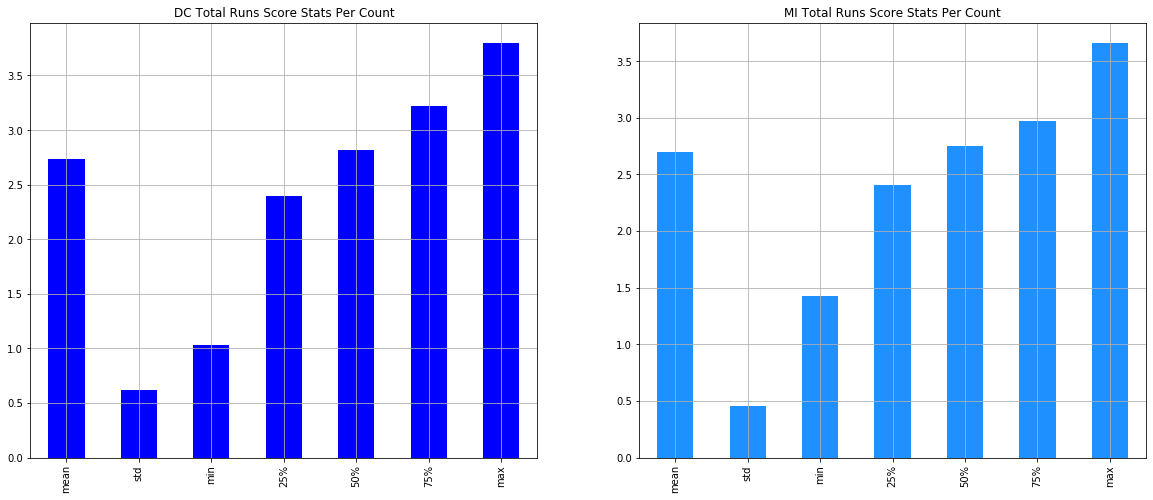

In [7]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
dc_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
mi_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
(dc_runs.describe()[1:]/dc_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True, color='blue')
(mi_runs.describe()[1:]/mi_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True, color='dodgerblue')
ax[0].set_title("DC Total Runs Score Stats Per Count")
ax[1].set_title("MI Total Runs Score Stats Per Count")

Text(0.5, 1.0, 'Percentage of Winning')

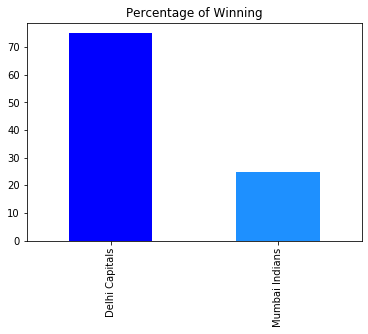

In [11]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2])) & (matches1['season']>=2018)]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
wins['Percentage Win Chance'].plot(kind='bar', color=['blue', 'dodgerblue'])
plt.title('Percentage of Winning')

# Rabada wickets

In [16]:
def wickets_by_bowler(bowler):
    wicket = list()
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        match =  delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id) & (delivery['player_dismissed']==1)]
        wicket.append(len(match))
    
    pct_wicket_chances = len(delivery[(delivery['bowler']==bowler) & (delivery['player_dismissed']==1)]['match_id'].unique()) / len(delivery[(delivery['bowler']==bowler)]['match_id'].unique()) 
    
    return (np.median(wicket), f"{round(pct_wicket_chances*100)}%")


In [17]:
wickets_by_bowler('K Rabada')

(2.0, '89%')

# Runs by Hardik Pandya

In [25]:
def runs_by_batsman(batsman):
    
    runs = list()
    for match_id in delivery[(delivery['batsman']==batsman)]['match_id'].unique():
        match = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id)]
        runs.append(sum(match['batsman_runs']))
    
    runs_df = pd.DataFrame({'Runs': runs})
    print(runs_df['Runs'].describe())

In [26]:
runs_by_batsman('HH Pandya')

count    53.000000
mean     18.924528
std      16.778935
min       0.000000
25%       7.000000
50%      15.000000
75%      28.000000
max      96.000000
Name: Runs, dtype: float64


Text(0.5, 1.0, 'Wickets Falls Hisotgram of MI')

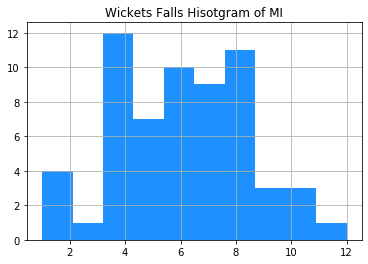

In [52]:
delivery[(delivery['batting_team']==team_2)].groupby('match_id').sum()['player_dismissed'].hist(color='dodgerblue')
plt.title('Wickets Falls Hisotgram of MI')

Since, the chances of wickets fall is upto 4 wickets, Hardik Pandya will come to bat.

# No-balls

In [36]:
mi_team = ['Q de Kock', 'SA Yadav', 'RG Sharma', 'Ishan Kishan', 'KH Pandya', 'HH Pandya', 'KA Pollard', 'NM Coulter-Nile', 'TA Boult', 'RD Chahar', 'JJ Bumrah']
dc_team = ['AM Rahane', 'S Dhawan','SS Iyer', 'RR Pant' ,'SO Hetmyer','A Nortje', 'TU Deshpande', 'K Rabada', 'R Ashwin', 'AR Patel', 'MP Stoinis']
teams = mi_team + dc_team

Text(0.5, 1.0, 'No of no-balls delivered by the today playing XI squad bowlers during 2016-2019')

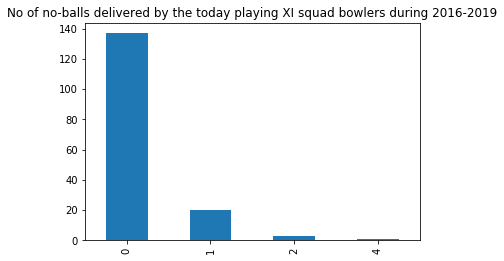

In [37]:
delivery[delivery['bowler'].isin(teams)].groupby('match_id').sum()['noball_runs'].value_counts().plot(kind='bar')
plt.title("No of no-balls delivered by the today playing XI squad bowlers during 2016-2019")

# Total Scores

In [49]:
def total_score(team):
    match = delivery[(delivery['batting_team']==team)]
    grouped = match.groupby('match_id').sum()
    grouped['total_runs'].plot(kind='hist', color='black', grid=True)
    print(grouped['total_runs'].describe())
    plt.title(f"Total score per match histogram of {team}")

count     58.000000
mean     158.551724
std       35.891734
min       60.000000
25%      139.000000
50%      163.500000
75%      186.750000
max      220.000000
Name: total_runs, dtype: float64


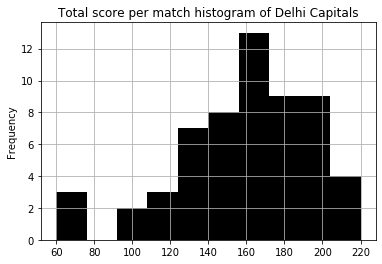

In [50]:
total_score(team_1)

count     61.000000
mean     164.688525
std       27.977694
min       87.000000
25%      147.000000
50%      168.000000
75%      181.000000
max      223.000000
Name: total_runs, dtype: float64


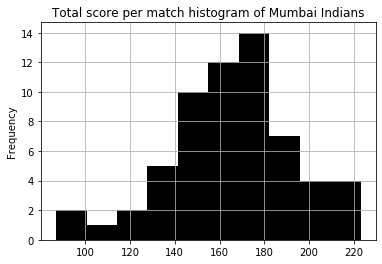

In [51]:
total_score(team_2)

# Summary

1. Using winner column and comparing central tendency measures of total scores per match for both teams, winning chances were calculated. 
2. Wickets per match by bowler was calculated using player_dismissed column. Median values were taken for all his matches. Percentage dismissal chances were calculated using matches with wickets and total matches ratio. 
3. A function to calculate runs by batsman per match using batsman_runs column and gives the mean value for all matches. Histogram of no. of wickets fall of MI per match was plotted and judging peak it can be said that H Pandya will bat today. 
4. No-balls in a match when bowler has played is taken out and bar plot suggests that generally there is high chances of zero no-balls. 
5. A function to calculate total team score per match using total_runs column was created which gives central tendency measures of values and plots histogram as well. Using values genereted for both teams, scores were summed and range estimated. 